#Cryptocurrency Volatility Prediction



 ##  Data Collection

We used a historical cryptocurrency dataset that contains daily price data for multiple cryptocurrencies.  
Key features:
- `date`
- `symbol`
- `open`, `high`, `low`, `close`
- `volume`
- `market_cap`

Our target is to predict **volatility**, defined as `(high - low)/open`.



In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [6]:
# Step 1: Upload the ZIP file
from google.colab import files
uploaded = files.upload()


Saving dataset.csv.zip to dataset.csv (2).zip


In [7]:
# Step 2: Extract the ZIP file
import zipfile
import os

with zipfile.ZipFile('dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Optional: List files to verify
os.listdir('/content/')


['.config',
 'dataset.csv (2).zip',
 'dataset.csv',
 'dataset.csv.zip',
 'dataset.csv (1).zip',
 'sample_data']

In [8]:
# Step 3: Load the CSV file
import pandas as pd

df = pd.read_csv('/content/dataset.csv')

# Preview the data
df.head()


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


##  Data Preprocessing

- Converted date to datetime
- Sorted the dataset by date
- Removed missing values
- Created new column `volatility = (high - low)/open`


In [9]:
# Check basic info
df.info()

# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort the data by date
df.sort_values(by='date', inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72946 non-null  int64  
 1   open         72946 non-null  float64
 2   high         72946 non-null  float64
 3   low          72946 non-null  float64
 4   close        72946 non-null  float64
 5   volume       72946 non-null  float64
 6   marketCap    72946 non-null  float64
 7   timestamp    72946 non-null  object 
 8   crypto_name  72946 non-null  object 
 9   date         72946 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.6+ MB


##  Exploratory Data Analysis

- Visualized trend of price & volume
- Checked distribution of volatility
- Plotted correlation heatmap


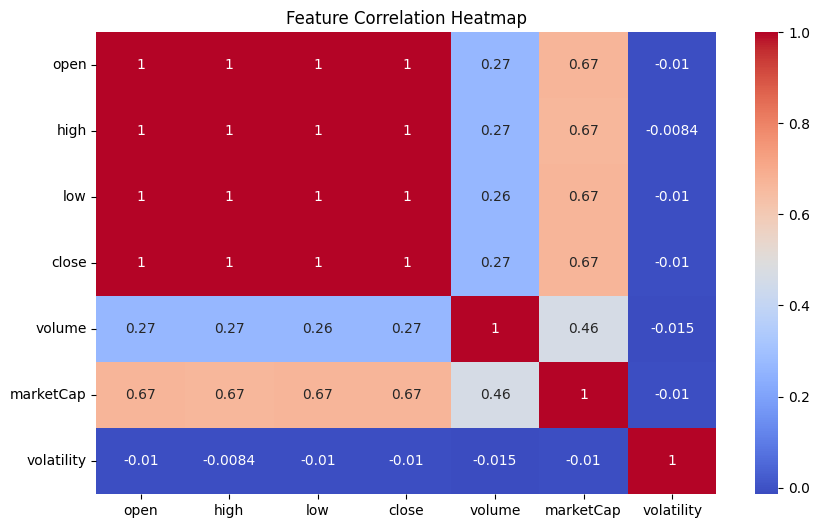

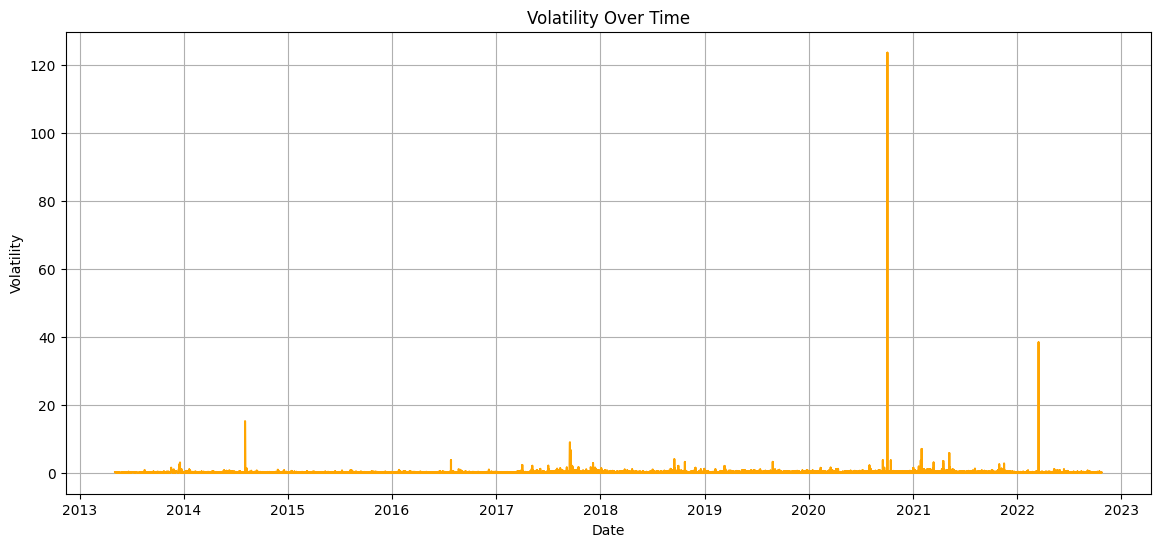

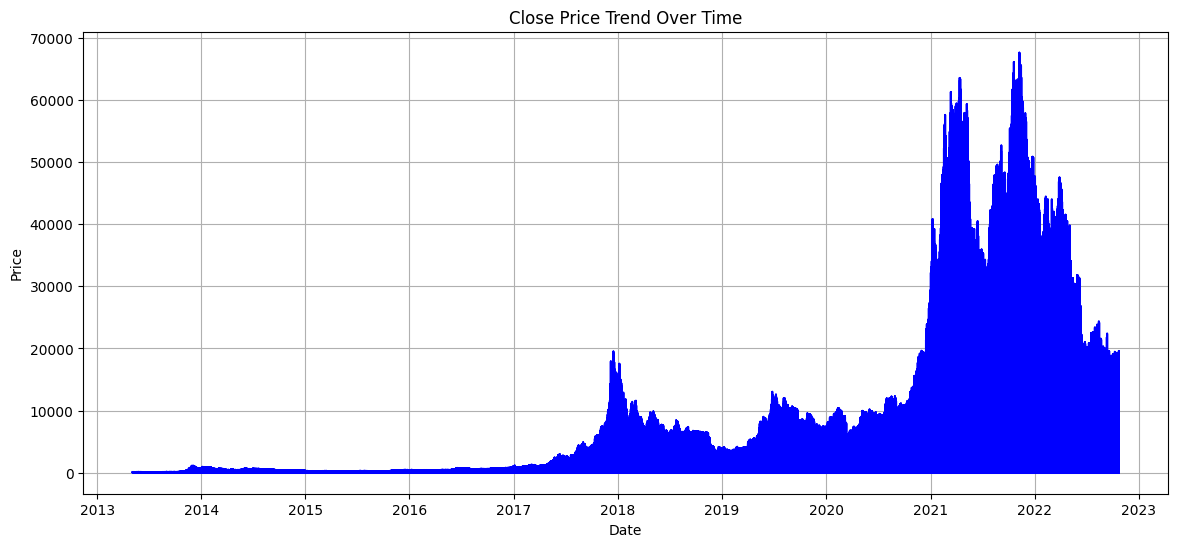

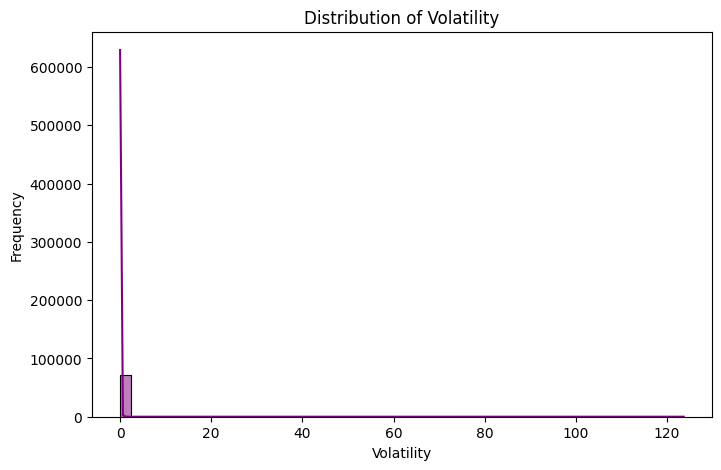

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1. Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['open', 'high', 'low', 'close', 'volume', 'marketCap', 'volatility']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ 2. Volatility Over Time
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['volatility'], color='orange')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

# ✅ 3. Close Price Over Time
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['close'], color='blue')
plt.title('Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# ✅ 4. Distribution of Volatility
plt.figure(figsize=(8,5))
sns.histplot(df['volatility'], bins=50, kde=True, color='purple')
plt.title('Distribution of Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.show()


##  Feature Engineering

Engineered new features:
- 7-day rolling average of `close`
- 7-day rolling standard deviation of `volatility`
- `liquidity_ratio = volume / market_cap`


In [16]:
# 🔸 Liquidity Ratio: Volume / Market Cap
df['liquidity_ratio'] = df['volume'] / df['marketCap']

# 🔸 7-day Moving Average of Closing Price
df['ma_7'] = df['close'].rolling(window=7).mean()

# 🔸 14-day Rolling Volatility (Standard Deviation of Daily Returns)
df['return'] = df['close'].pct_change()
df['rolling_volatility_14'] = df['return'].rolling(window=14).std()

# 🔸 Bollinger Bands (20-day Moving Average ± 2 * Std Dev)
df['ma_20'] = df['close'].rolling(window=20).mean()
df['std_20'] = df['close'].rolling(window=20).std()
df['bollinger_upper'] = df['ma_20'] + (2 * df['std_20'])
df['bollinger_lower'] = df['ma_20'] - (2 * df['std_20'])

# ✅ Drop NA rows generated by rolling functions
df.dropna(inplace=True)

# Final check
df.head()


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date,...,rolling_mean_close,rolling_volatility,liquidity_ratio,ma_7,return,rolling_volatility_14,ma_20,std_20,bollinger_upper,bollinger_lower
19,19,3.281010,3.331850,2.777200,2.824300,0.0,4.984757e+07,2013-05-14T23:59:59.999Z,Litecoin,2013-05-14,...,51.028936,0.046495,0.0,51.028936,-0.974670,16.712076,58.807758,56.943121,172.693999,-55.078483
20,20,111.400002,115.809998,103.500000,114.220001,0.0,1.274624e+09,2013-05-15T23:59:59.999Z,Bitcoin,2013-05-15,...,66.867656,0.047996,0.0,66.867656,39.441879,17.914627,58.723258,56.855110,172.433479,-54.986963
21,21,2.823990,3.035820,2.639250,2.935450,0.0,5.189165e+07,2013-05-15T23:59:59.999Z,Litecoin,2013-05-15,...,66.819942,0.052496,0.0,66.819942,-0.974300,17.541525,58.690486,56.888741,172.467968,-55.086996
22,22,114.220001,118.760002,112.199997,118.760002,0.0,1.325727e+09,2013-05-16T23:59:59.999Z,Bitcoin,2013-05-16,...,67.357085,0.049147,0.0,67.357085,39.457170,18.619266,59.013486,57.226479,173.466444,-55.439472
23,23,2.929740,2.967670,2.685110,2.919120,0.0,5.168588e+07,2013-05-16T23:59:59.999Z,Litecoin,2013-05-16,...,50.919816,0.042528,0.0,50.919816,-0.975420,18.619638,58.990880,57.249701,173.490282,-55.508523


##  Model Selection & Training

We used **Random Forest Regressor** to predict volatility.  
Features used:
- `open`, `high`, `low`, `close`, `volume`, `market_cap`
- `rolling_mean_close`, `rolling_volatility`, `liquidity_ratio`

Data was split into 80% training and 20% testing sets.


In [10]:
from google.colab import files
uploaded = files.upload()


Saving dataset.csv.zip to dataset.csv.zip


In [11]:
import zipfile
import pandas as pd

# Replace with the exact filename you uploaded if different
with zipfile.ZipFile('dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Load the dataset
df = pd.read_csv('/content/dataset.csv')

# Preview
df.head()


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [16]:
#  Step 1: Create Target Variable
df['volatility'] = (df['high'] - df['low']) / df['open']

#  Step 2: Create missing features
df['rolling_mean_close'] = df['close'].rolling(window=7).mean()
df['rolling_volatility'] = df['volatility'].rolling(window=14).std()
df['liquidity_ratio'] = df['volume'] / df['close']

#  Step 3: Drop any rows with NaNs generated by rolling functions
df.dropna(inplace=True)


In [18]:
# ✅ Step 1: Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'rolling_mean_close', 'rolling_volatility', 'liquidity_ratio']
X = df[features].copy()
y = df['volatility'].copy()

# ✅ Step 2: Handle any infinite values (just in case)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y[X.index]  # align y with X

# ✅ Step 3: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 4: Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Step 5: Train Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# ✅ Step 6: Make predictions
y_pred = model.predict(X_test_scaled)

# ✅ Step 7: Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


🔍 Evaluation Metrics:
RMSE: 0.1875
MAE: 0.0302
R² Score: -2.1350


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ✅ Compute Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Manually take sqrt
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 0.1875
Mean Absolute Error (MAE): 0.0302
R² Score: -2.1350


# High-Level Design (HLD) – Cryptocurrency Volatility Prediction

## Objective
Predict the **volatility** of cryptocurrencies using historical price, volume, and market cap data.

## System Components

### 1. Data Source
- Input: CSV file containing OHLC, volume, market cap for 50+ cryptocurrencies.

### 2. Data Preprocessing Module
- Handles missing values
- Date parsing
- Sorting and normalization

### 3. Feature Engineering Module
- Calculates volatility, liquidity, moving averages, Bollinger Bands

### 4. Machine Learning Module
- Model: Linear Regression (can be upgraded to LSTM or XGBoost)
- Target: Volatility
- Features: Technical indicators + raw OHLC

### 5. Evaluation Module
- Metrics: RMSE, MAE, R² Score
- Visualization: Actual vs Predicted scatter plot

### 6. Deployment Layer (Optional)
- Web interface using Streamlit for input + output

## Architecture Diagram



# Low-Level Design (LLD) – Cryptocurrency Volatility Prediction

## 1. Data Preprocessing
- `dropna()` to remove rows with missing OHLC/volume data
- Forward-fill for minor gaps
- `pd.to_datetime()` for parsing date
- `MinMaxScaler()` if normalization needed

## 2. Feature Engineering
- `volatility = (high - low) / open`
- `liquidity = volume / market_cap`
- `ma7 = close.rolling(7).mean()`
- Bollinger Bands using standard deviation on 14-day window

## 3. Model Training
- **Scikit-learn** Linear Regression
- `train_test_split` with 80/20 split
- `model.fit(X_train, y_train)`

## 4. Evaluation
- Use `mean_squared_error`, `mean_absolute_error`, `r2_score`
- Scatter plot: `plt.scatter(y_test, y_pred)`

## 5. File Structure (in Colab or repo)


# Pipeline Architecture – Cryptocurrency Volatility Prediction



# Step 1: Ingestion
df = pd.read_csv("crypto_data.csv")

# Step 2: Preprocessing
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Step 3: Feature Engineering
df['volatility'] = (df['high'] - df['low']) / df['open']
df['liquidity'] = df['volume'] / df['market_cap']
df['ma7'] = df['close'].rolling(7).mean()
df['stddev'] = df['close'].rolling(14).std()

# Step 4: Modeling
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Evaluation
from sklearn.metrics import r2_score
print("R² Score:", r2_score(y_test, y_pred))
